## Perform surgery on reference model and train on query dataset without cell type labels

In [1]:
import os
import sys

sys.path.append('/root/host_home/luca/utils')
from functions import plot_training_history, map_gene_symbols_to_ensembl

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import scanpy as sc

import scvi
import scarches as sca

torch.cuda.is_available()

 captum (see https://github.com/pytorch/captum).
/usr/local/lib/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


False

In [2]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
# TODO maybe this is what achieved high accuracy>
torch.set_float32_matmul_precision("high")
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [14]:
ref_path = '/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_b128_lay4_h1024_wuSep_epocs300-300/'
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries'
ext_name = "Hu_Zhang_2023_NSCLC"
name = 'Hu_wu'
name_short = name.split('_')[0]
surgery_path = f'{backup_dir}/{name}'
surgery_before = f'{backup_dir}/{name_short}'

In [4]:
condition_key = 'dataset2'
cell_type_key = 'cell_type_tumor'

## Import

In [16]:
target_adata = sc.read_h5ad(f'{backup_dir}/filtered_{ext_name}.h5ad')
target_adata.obs[cell_type_key] = 'Unknown'
target_adata

AnnData object with n_obs × n_vars = 92330 × 24292
    obs: 'Sample', 'Patient', 'Resource', 'Sex', 'Age', 'Clinical Stage', 'Pathology', 'PD1 Antibody', 'Chemotherapy', 'Pathologic Response', 'Residual Tumor', 'RECIST', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'cell_type_tumor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

WE DO THIS SO THAT WE DO NOT COLLIDE WITH THE BAROCEDES OF THE REAF ATLAS, BUT IF YOU DONT HAVE BARCOEDS DUNT RUN THIS

In [17]:
target_adata.obs

Sample Patient                Resource   Sex   Age  \
barcode                                                                       
BD_immune01_612637  BD_immune01     P01    Pre-treatment biopsy  Male  68.0   
BD_immune01_698718  BD_immune01     P01    Pre-treatment biopsy  Male  68.0   
BD_immune01_509246  BD_immune01     P01    Pre-treatment biopsy  Male  68.0   
BD_immune01_101435  BD_immune01     P01    Pre-treatment biopsy  Male  68.0   
BD_immune01_400370  BD_immune01     P01    Pre-treatment biopsy  Male  68.0   
...                         ...     ...                     ...   ...   ...   
BD_immune13_111313  BD_immune13     P13  Post-treatment surgery  Male  59.0   
BD_immune13_791956  BD_immune13     P13  Post-treatment surgery  Male  59.0   
BD_immune14_462072  BD_immune14     P14  Post-treatment surgery  Male  79.0   
BD_immune14_124095  BD_immune14     P14  Post-treatment surgery  Male  79.0   
BD_immune15_20126   BD_immune15     P15  Post-treatment surgery  Male  55.0   

                   Clinical Stage Pathology PD1 Antibody  \
barcode                                                    
BD_immune01_612637           IIIA  Squamous  Toripalimab   
BD_immune01_698718           IIIA  Squamous  Toripalimab   
BD_immune01_509246           IIIA  Squamous  Toripalimab   
BD_immune01_101435           IIIA  Squamous  Toripalimab   
BD_immune01_400370           IIIA  Squamous  Toripalimab   
...                           ...       ...          ...   
BD_immune13_111313           IIIA  Squamous   Sintilimab   
BD_immune13_791956           IIIA  Squamous   Sintilimab   
BD_immune14_462072           IIIA  Squamous   Sintilimab   
BD_immune14_124095           IIIA  Squamous   Sintilimab   
BD_immune15_20126            IIIA     Adeno   Sintilimab   

                               Chemotherapy Pathologic Response  ...  \
barcode                                                          ...   
BD_immune01_612637    Carboplatin+Docetaxel                  NE  ...   
BD_immune01_698718    Carboplatin+Docetaxel                  NE  ...   
BD_immune01_509246    Carboplatin+Docetaxel                  NE  ...   
BD_immune01_101435    Carboplatin+Docetaxel                  NE  ...   
BD_immune01_400370    Carboplatin+Docetaxel                  NE  ...   
...                                     ...                 ...  ...   
BD_immune13_111313  Carboplatin+Gemcitabine                NMPR  ...   
BD_immune13_791956  Carboplatin+Gemcitabine                NMPR  ...   
BD_immune14_462072  Carboplatin+Gemcitabine                 MPR  ...   
BD_immune14_124095  Carboplatin+Gemcitabine                 MPR  ...   
BD_immune15_20126    Carboplatin+Pemetrexed                NMPR  ...   

                   total_counts log1p_total_counts  \
barcode                                              
BD_immune01_612637      45924.0          10.734765   
BD_immune01_698718      41596.0          10.635783   
BD_immune01_509246      31883.0          10.369860   
BD_immune01_101435      31458.0          10.356441   
BD_immune01_400370       9912.0           9.201602   
...                         ...                ...   
BD_immune13_111313      14235.0           9.563529   
BD_immune13_791956      12655.0           9.445887   
BD_immune14_462072      10994.0           9.305196   
BD_immune14_124095       7300.0           8.895766   
BD_immune15_20126        4989.0           8.515191   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
barcode                                                                       
BD_immune01_612637                   20.873617                    28.157390   
BD_immune01_698718                   17.605058                    25.488028   
BD_immune01_509246                   26.628611                    33.183828   
BD_immune01_101435                   17.795155                    24.887151   
BD_immune01_400370                   26.251009                    35.401533   
...                    

In [18]:
target_adata.obs.index = f'{name_short}_' + target_adata.obs.index.astype('string')
target_adata.obs_names_make_unique()

## Convert to Ensembl

In [19]:
output_csv_path = f'{surgery_before}/{name_short}_ensembl.csv'

try:
    os.mkdir(surgery_before)
    print(f"Directory '{surgery_before}' created successfully.")
except FileExistsError:
    print(f"Directory '{surgery_before}' already exists.")

target_adata.var['symbol'] = target_adata.var.index
if not os.path.exists(output_csv_path):
    target_adata = map_gene_symbols_to_ensembl(target_adata, output_csv_path)
else:
    ensembl = pd.read_csv(output_csv_path)
    target_adata.var.index = ensembl.ensembl_gene_id.astype(str)
    target_adata.var['ensembl_gene_id'] = target_adata.var.index


Directory '/root/datos/maestria/netopaas/luca_explore/surgeries/Hu' already exists.


In [20]:
target_adata.var

mito  n_cells_by_counts  mean_counts  log1p_mean_counts  \
ensembl_gene_id                                                             
ENSG00000121410  False                 86     0.000964           0.000963   
ENSG00000268895  False               1565     0.018770           0.018596   
ENSG00000148584  False                 52     0.000563           0.000563   
ENSG00000175899  False              12175     1.276660           0.822709   
ENSG00000245105  False                651     0.007549           0.007521   
...                ...                ...          ...                ...   
ENSG00000070476  False               8164     0.107679           0.102267   
ENSG00000203995  False                863     0.010842           0.010783   
ENSG00000162378  False              13106     0.208405           0.189301   
ENSG00000285443  False              52508     2.292299           1.191586   
ENSG00000074755  False               8887     0.111957           0.106122   

                 pct_dropout_by_counts  total_counts  log1p_total_counts  \
ensembl_gene_id                                                            
ENSG00000121410              99.906856          89.0            4.499810   
ENSG00000268895              98.304993        1733.0            7.458186   
ENSG00000148584              99.943680          52.0            3.970292   
ENSG00000175899              86.813603      117874.0           11.677380   
ENSG00000245105              99.294920         697.0            6.548219   
...                                ...           ...                 ...   
ENSG00000070476              91.157804        9942.0            9.204624   
ENSG00000203995              99.065309        1001.0            6.909753   
ENSG00000162378              85.805264       19242.0            9.864902   
ENSG00000285443              43.130077      211648.0           12.262685   
ENSG00000074755              90.374743       10337.0            9.243582   

                   symbol  ensembl_gene_id  
ensembl_gene_id                             
ENSG00000121410      A1BG  ENSG00000121410  
ENSG00000268895  A1BG-AS1  ENSG00000268895  
ENSG00000148584      A1CF  ENSG00000148584  
ENSG00000175899       A2M  ENSG00000175899  
ENSG00000245105   A2M-AS1  ENSG00000245105  
...                   ...              ...  
ENSG00000070476      ZXDC  ENSG00000070476  
ENSG00000203995    ZYG11A  ENSG00000203995  
ENSG00000162378    ZYG11B  ENSG00000162378  
ENSG00000285443       ZYX  ENSG00000285443  
ENSG00000074755     ZZEF1  ENSG00000074755  

[24292 rows x 9 columns]

In [21]:
target_adata = target_adata[:, ~target_adata.var.index.duplicated(keep='first')].copy() # create a copy to avoid modifying the original object
target_adata.var.index = pd.Index(target_adata.var.index) # convert to a plain Index object, which enforces uniqueness

## Prepare query

In [22]:
adata_query = sca.models.SCANVI.prepare_query_anndata(
    adata = target_adata,
    # return_reference_var_names=True,
    reference_model = ref_path,
    inplace=False)

INFO     File                                                                                                      
         /root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_b128_lay4_h1024
         _wuSep_epocs300-300/model.pt already downloaded                                                           


/usr/local/lib/python3.11/site-packages/scvi/model/base/_save_load.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=map_locat

INFO     Found 86.35000000000001% reference vars in query data.                                                    


Some fixes to be able to serialize

In [23]:
adata_query.obs.index.name = 'index'
adata_query.obs.index = adata_query.obs.index.astype("O")

## Train

In [24]:
adata_query.obs[condition_key] = name_short
adata_query.obs['sample'] = adata_query.obs['Sample']
adata_query

AnnData object with n_obs × n_vars = 92330 × 6000
    obs: 'Sample', 'Patient', 'Resource', 'Sex', 'Age', 'Clinical Stage', 'Pathology', 'PD1 Antibody', 'Chemotherapy', 'Pathologic Response', 'Residual Tumor', 'RECIST', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'cell_type_tumor', 'dataset2', 'sample'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'symbol', 'ensembl_gene_id'

In [26]:

# scvi.settings.batch_size = 1024

model = sca.models.SCANVI.load_query_data(
    adata_query,
    ref_path,
    freeze_dropout = True,
)
model._unlabeled_indices = np.arange(adata_query.n_obs)
model._labeled_indices = []
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", len(model._unlabeled_indices))

INFO     File                                                                                                      
         /root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_b128_lay4_h1024
         _wuSep_epocs300-300/model.pt already downloaded                                                           


/usr/local/lib/python3.11/site-packages/scvi/model/base/_save_load.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=map_locat

Labelled Indices:  0
Unlabelled Indices:  92330


In [25]:
adata_query.write_h5ad(f'{surgery_path}/query.h5ad')
# adata_query = sc.read_h5ad(f'{surgery_path}/query.h5ad')
adata_query.obs

Sample Patient                Resource   Sex  \
index                                                                      
Hu_BD_immune01_612637  BD_immune01     P01    Pre-treatment biopsy  Male   
Hu_BD_immune01_698718  BD_immune01     P01    Pre-treatment biopsy  Male   
Hu_BD_immune01_509246  BD_immune01     P01    Pre-treatment biopsy  Male   
Hu_BD_immune01_101435  BD_immune01     P01    Pre-treatment biopsy  Male   
Hu_BD_immune01_400370  BD_immune01     P01    Pre-treatment biopsy  Male   
...                            ...     ...                     ...   ...   
Hu_BD_immune13_111313  BD_immune13     P13  Post-treatment surgery  Male   
Hu_BD_immune13_791956  BD_immune13     P13  Post-treatment surgery  Male   
Hu_BD_immune14_462072  BD_immune14     P14  Post-treatment surgery  Male   
Hu_BD_immune14_124095  BD_immune14     P14  Post-treatment surgery  Male   
Hu_BD_immune15_20126   BD_immune15     P15  Post-treatment surgery  Male   

                        Age Clinical Stage Pathology PD1 Antibody  \
index                                                               
Hu_BD_immune01_612637  68.0           IIIA  Squamous  Toripalimab   
Hu_BD_immune01_698718  68.0           IIIA  Squamous  Toripalimab   
Hu_BD_immune01_509246  68.0           IIIA  Squamous  Toripalimab   
Hu_BD_immune01_101435  68.0           IIIA  Squamous  Toripalimab   
Hu_BD_immune01_400370  68.0           IIIA  Squamous  Toripalimab   
...                     ...            ...       ...          ...   
Hu_BD_immune13_111313  59.0           IIIA  Squamous   Sintilimab   
Hu_BD_immune13_791956  59.0           IIIA  Squamous   Sintilimab   
Hu_BD_immune14_462072  79.0           IIIA  Squamous   Sintilimab   
Hu_BD_immune14_124095  79.0           IIIA  Squamous   Sintilimab   
Hu_BD_immune15_20126   55.0           IIIA     Adeno   Sintilimab   

                                  Chemotherapy Pathologic Response  ...  \
index                                                               ...   
Hu_BD_immune01_612637    Carboplatin+Docetaxel                  NE  ...   
Hu_BD_immune01_698718    Carboplatin+Docetaxel                  NE  ...   
Hu_BD_immune01_509246    Carboplatin+Docetaxel                  NE  ...   
Hu_BD_immune01_101435    Carboplatin+Docetaxel                  NE  ...   
Hu_BD_immune01_400370    Carboplatin+Docetaxel                  NE  ...   
...                                        ...                 ...  ...   
Hu_BD_immune13_111313  Carboplatin+Gemcitabine                NMPR  ...   
Hu_BD_immune13_791956  Carboplatin+Gemcitabine                NMPR  ...   
Hu_BD_immune14_462072  Carboplatin+Gemcitabine                 MPR  ...   
Hu_BD_immune14_124095  Carboplatin+Gemcitabine                 MPR  ...   
Hu_BD_immune15_20126    Carboplatin+Pemetrexed                NMPR  ...   

                      pct_counts_in_top_50_genes pct_counts_in_top_100_genes  \
index                                                                          
Hu_BD_immune01_612637                  20.873617                   28.157390   
Hu_BD_immune01_698718                  17.605058                   25.488028   
Hu_BD_immune01_509246                  26.628611                   33.183828   
Hu_BD_immune01_101435                  17.795155                   24.887151   
Hu_BD_immune01_400370                  26.251009                   35.401533   
...                                          ...                         ...   
Hu_BD_immune13_111313                  27.214612                   34.092027   
Hu_BD_immune13_791956                  23.484789                   31.600158   
Hu_BD_immune14_462072                  22.894306                   30.598508   
Hu_BD_immune14_124095                  24.767123                   31.301370   
Hu_BD_immune15_20126                   25.696532                   33.172981   

                       pct_counts_in_top_200_genes  \
index                                                
Hu_BD_immune01_6

In [ ]:
scvi.settings.num_workers = 8

early_stopping_kwargs = {
    "early_stopping_monitor": "elbo_validation",
    "early_stopping_patience": 15,
    "early_stopping_min_delta": 0.01,
}
# # This very importanto for actual covnergence... we have seen we tend to hit local minima and this helps i navoiding but only once...  a peridic approach would ve good
#  ofr understanding a little bit of reduce https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau
# The plteau is defined when the minimum of the loss does not decrease for 9 epochs. So to be able to take advantage of this the patience has to be bigger than the early stopping
plan_kwargs= {
    # "weight_decay": 0.0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 9,
    "lr_factor": 0.1,
}

model.train(
    max_epochs=200,
    check_val_every_n_epoch=3,
    batch_size=128,
    early_stopping=True,
    **early_stopping_kwargs, 
    plan_kwargs=plan_kwargs
)

INFO     Training for 200 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Epoch 1/200:   0%|                                                                                                                                                                         | 0/200 [00:00<?, ?it/s]

Epoch 64/200:  32%|██████████████████████████████▍                                                                | 64/200 [1:12:33<2:34:10, 68.02s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=1.75e+3]
Monitored metric elbo_validation did not improve in the last 15 records. Best score: 1770.599. Signaling Trainer to stop.


In [28]:
model.history.keys()

dict_keys(['lr-Adam', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

In [31]:
history_keys = [
    'lr-Adam', 'validation_loss', 'elbo_validation', 
    'reconstruction_loss_validation', 'kl_local_validation', 
    'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 
    'kl_local_train'
]

# Assuming scanvae.history contains the training history
plot_training_history(model.history, history_keys)

### Save

In [26]:
# model.save(f'{surgery_path}/', overwrite=True)
model = sca.models.SCANVI.load(surgery_path, adata_query)

INFO     File /root/datos/maestria/netopaas/luca_explore/surgeries/Hu_wu/model.pt already downloaded               


/usr/local/lib/python3.11/site-packages/scvi/model/base/_save_load.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=map_locat

In [27]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.write_h5ad(f'{surgery_path}/query_latent.h5ad')
# query_latent = sc.read_h5ad(f'{surgery_path}/query_latent.h5ad')

## Get predictions (VAE)

### Import

In [13]:
!ls -alh $surgery_path

total 188M
drwxr-xr-x  2 root root    4 Feb  3 21:44 .
drwxr-xr-x 35 1004 root  110 Feb  6 19:10 ..
-rw-r--r--  1 root root 183M Feb  3 21:43 model.pt
-rw-r--r--  1 root root 7.1M Feb  3 21:44 query_latent.h5ad


In [ ]:
import scvi
adata_query = sc.read_h5ad(f'{surgery_path}/query.h5ad')
model = scvi.model.SCANVI.load(surgery_path, adata_query)
# query_latent = sc.AnnData(model.get_latent_representation())
print(adata_query)

### Predict

In [28]:
query_latent.obs['cell_type'] = model.predict()
query_latent.obs['batch'] = adata_query.obs[condition_key].tolist()
query_latent.obs.index = adata_query.obs.index

## Comparison

### Merge their predictions

We will be comparing against their annotation so we will have to do ajoin in the barcodes. 
We must also import their annots.
In the Zuani notebook we had to do an elaborate barcode matching but here there is no need. Consult there if needed.

Theirpredictios are very general. Bt the metafdata is pretty well done.

In [34]:
annots_df = target_adata.obs.loc[:, 'assigned_cell_type']
query_latent.obs.index = adata_query.obs.index
annots_joined = pd.DataFrame.join(query_latent.obs, annots_df, how='left')
annots_joined

cell_type batch  assigned_cell_type
index                                                            
Deng_0                        Mast cell  P001                   5
Deng_1       T cell CD8 effector memory  P001                   0
Deng_2             T cell CD8 activated  P001                   0
Deng_3             T cell CD8 activated  P001                   0
Deng_4                        Mast cell  P001                   5
...                                 ...   ...                 ...
Deng_421706                  T cell CD4  P049                   1
Deng_421707                 Plasma cell  P049                   4
Deng_421708                      B cell  P049                   4
Deng_421709        T cell CD8 activated  P049                   0
Deng_421710                      B cell  P049                   4

[421711 rows x 3 columns]

In [35]:
query_latent.obs = annots_joined
query_latent.obs.rename(columns = {'assigned_cell_type': 'source_type'}, inplace=True)
query_latent.obs['source_type'].isna().sum()

0

In [36]:
cell_map = {0 : 'T',
1 : 'Myeloid',
2 : 'Epithelial',
3 : 'NK',
4 : 'B',
5 : 'MAST',
6: 'Fibroblasts',
7: 'Endothelial'
}

query_latent.obs['source_type'] = query_latent.obs['source_type'].apply(lambda x: cell_map[x])

We will start comparing the types, to do that it is very important to have the article in mind and the caveat sof how they annotated their cells.

In this figure we can see the proportions of types of cells and the types of samples that were analyzed.

It is also useful to have a visualization of the main kind of cells that are in the alveoli:



### UMAPs

In [29]:
import numba
numba.set_num_threads(8)

sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)

/tmp/ipykernel_2101180/2499539482.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(query_latent)


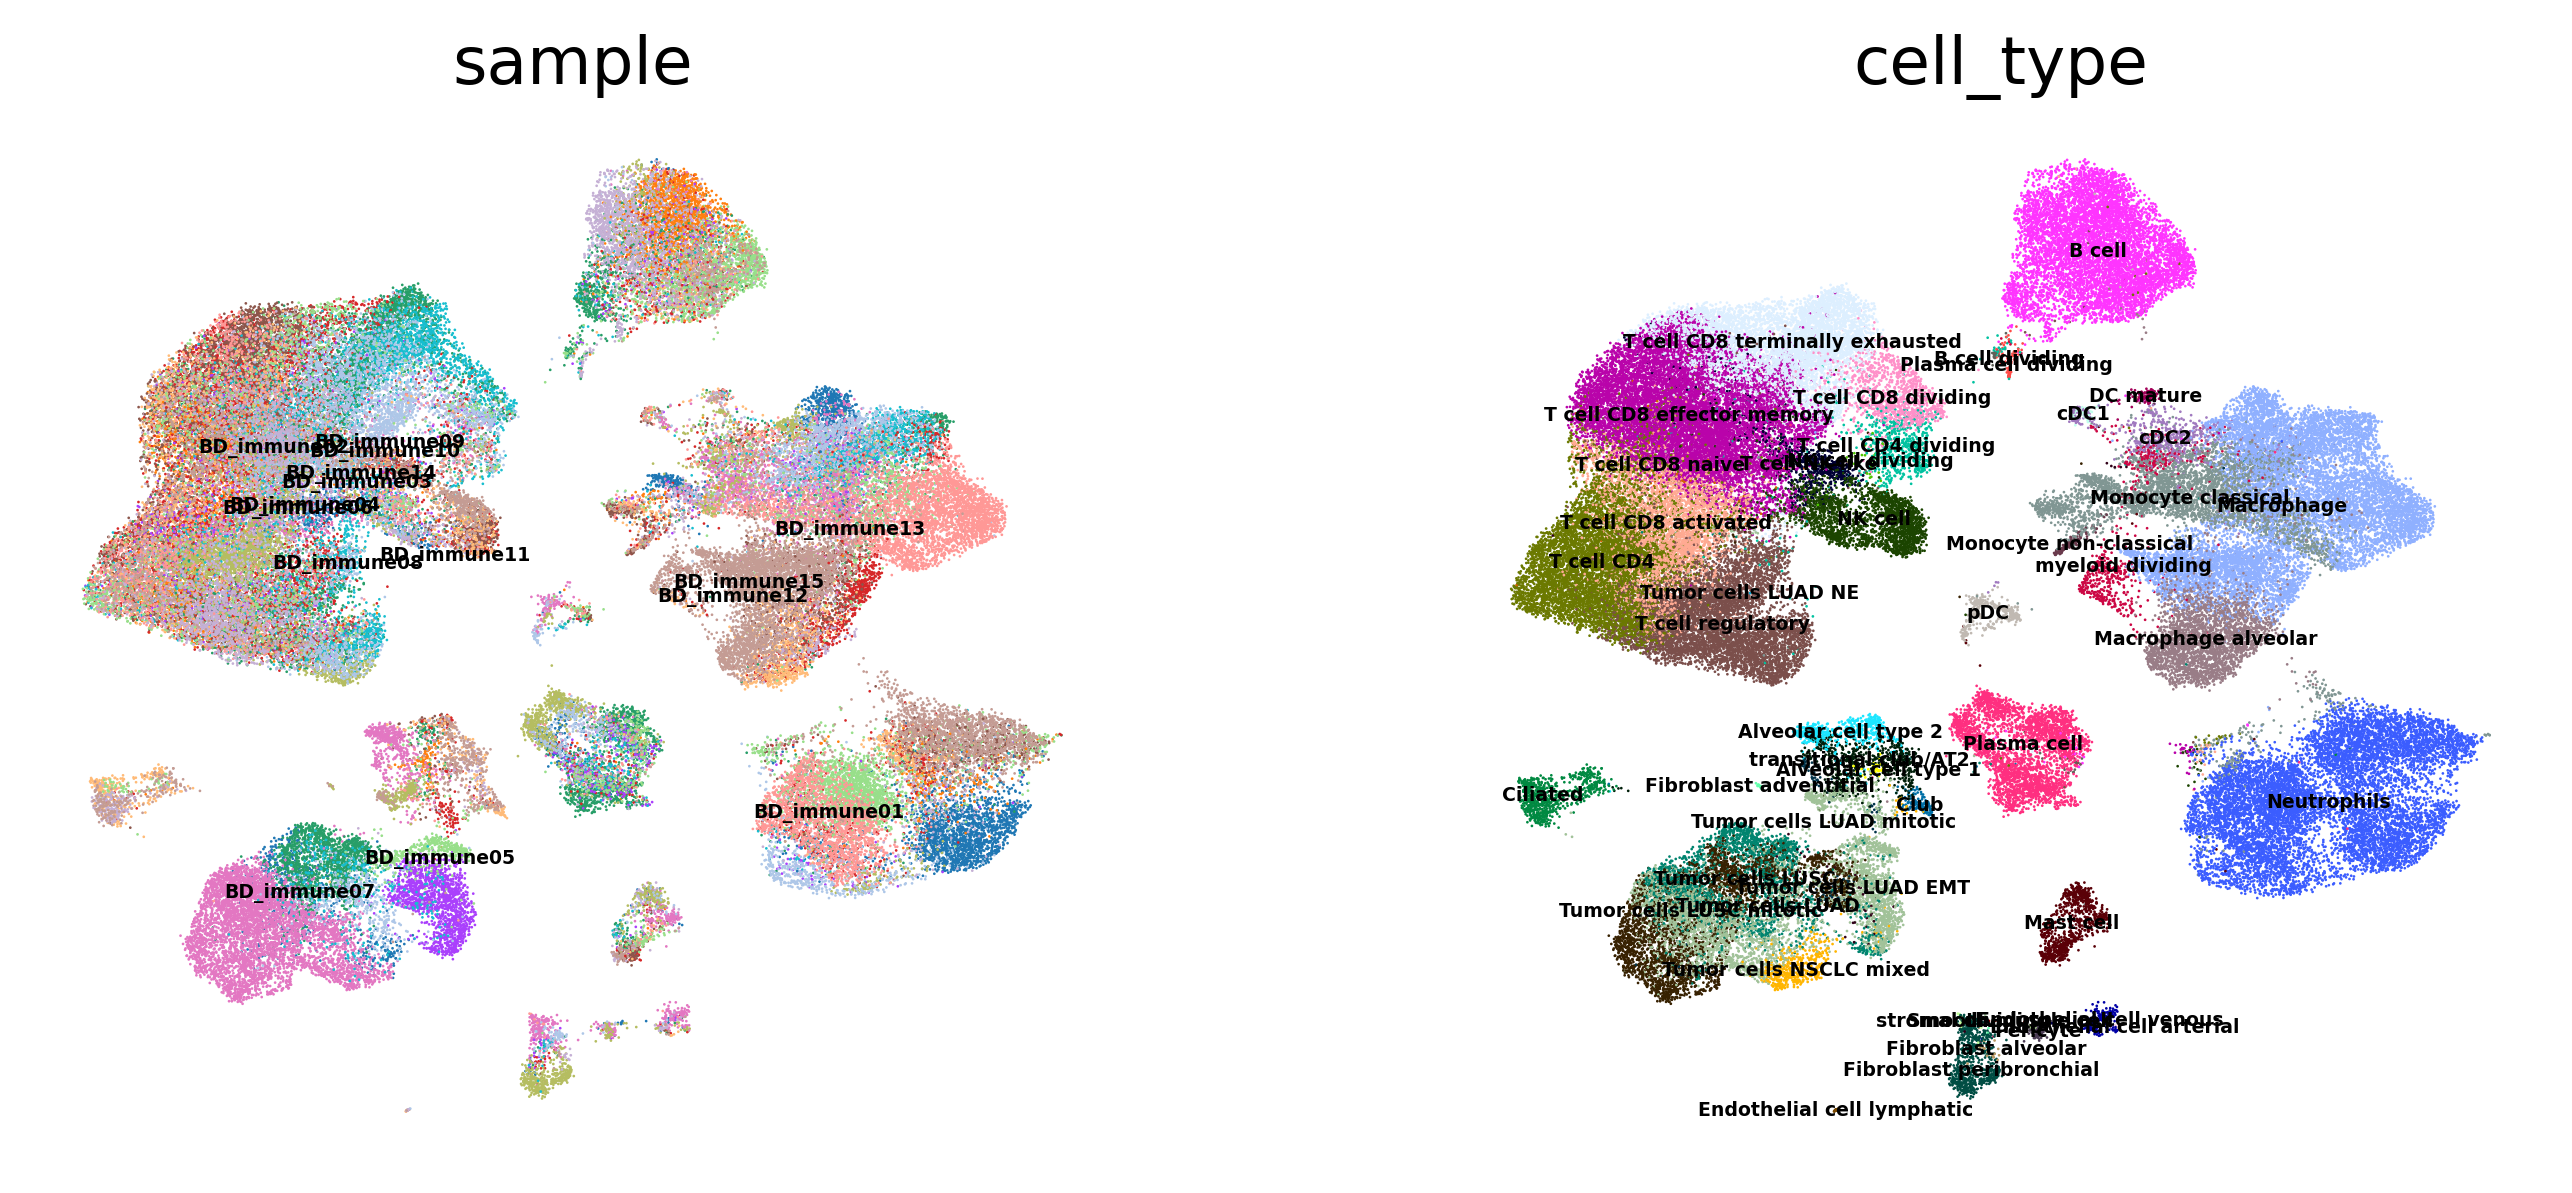

In [30]:
# query_plot = query_latent[query_latent.obs.source_type.str.contains('').astype(bool)]
# query_plot = query_plot[np.logical_not(query_plot.obs.source_type.isna())]

query_latent.obs['sample'] = adata_query.obs['Sample']

sc.settings.set_figure_params(dpi=170, frameon=False)
# Plot the UMAP with 'cell_type' on the first row
sc.pl.umap(
    query_latent,
    color=['sample', "cell_type"],
    ncols=2,
    legend_fontsize=4,
    legend_loc='on data'
)

One can see that for many cell types there is a main accumulation where the prediction and annotation intersect, but there are many outliers.

It is difficult to see very much here, because of the abundance of types, the colours resemble each other. An interactive UMAP, may help us in locating the cell types we are wishing to compare.

### Interactive UMAPs

In [167]:
# Extract UMAP coordinates and metadata
umap_coords = query_latent.obsm['X_umap']  # UMAP coordinates
metadata = query_latent.obs  # Metadata

# Create a DataFrame for Altair
df = pd.DataFrame(umap_coords, columns=['UMAP1', 'UMAP2'])
df.index = metadata.index
df = df.join(metadata)  # Join metadata with UMAP coordinates

In [ ]:
import altair as alt

# Define your Altair chart
chart = alt.Chart(df.sample(5000)).mark_point().encode(
    x='UMAP1',
    y='UMAP2',
    color='source_type',
    tooltip='cell_type',
).interactive()

# Display the chart
chart

### Confusion Matrix Heatmap

A relative abundance heatmap is more useful for checking the intersection of our predicted cell types against their marker gene annotated cell types.


This next one with clustering in the rows lets us see the groups of their cell types, that intersect with our predicted cell types.

In [41]:
import seaborn as sns

df = query_latent.obs.groupby(["source_type", "cell_type"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)
# corr_matrix = norm_df.corr()

axs = sns.clustermap(norm_df, row_cluster=True, cmap="viridis", cbar_kws={'label': 'Relative predicted abundance'},
                    figsize=(20,10))

# axs.ax_heatmap.set_xlabel('Predicted')
# axs.ax_heatmap.set_ylabel('Source')

As we can see the types sort of line up. The NK Cells have some ambiguity, with T cells but a transition is possible. Plasma cells are precuros of B and Mast cells so tha tis ok. The EMT cells have ambiguity with fibors and a little myeloid which is possible. But what is strange is that the myeloid dividng are very confused with T cells.

We can cluster for the predicted types to get other info:

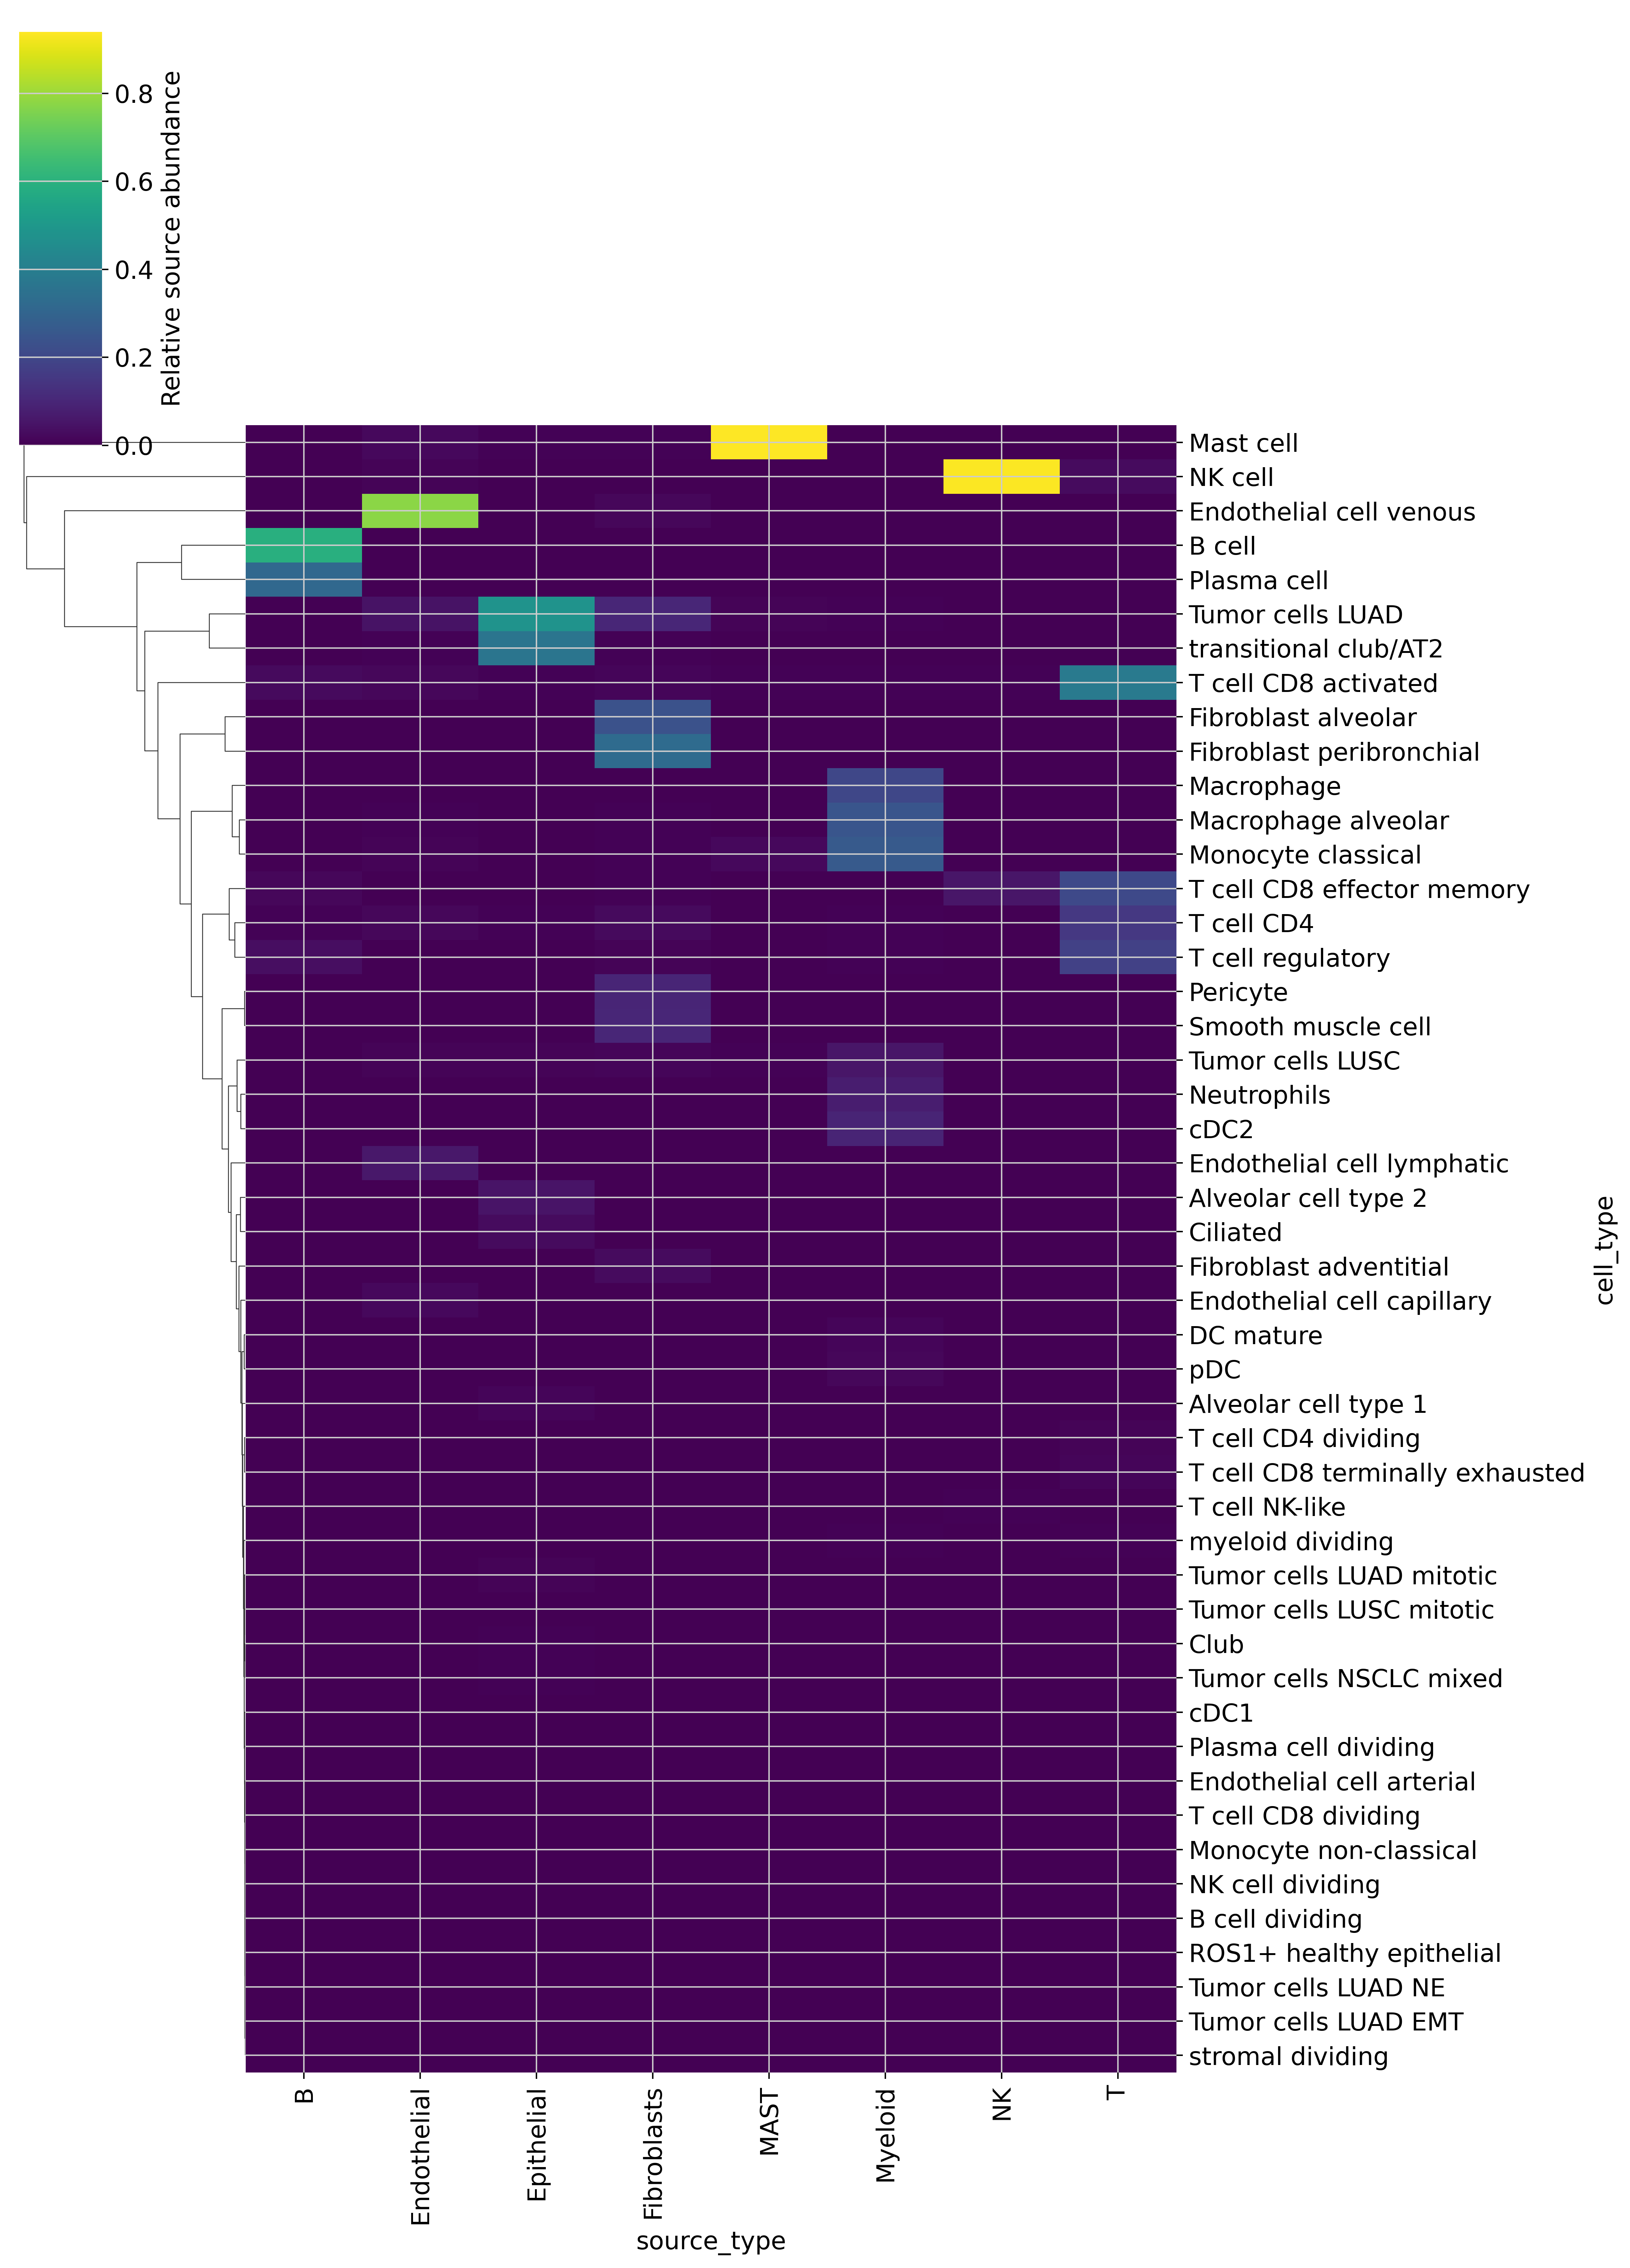

In [42]:
df = query_latent.obs.groupby(["cell_type", "source_type"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)
# corr_matrix = norm_df.corr()

axs = sns.clustermap(norm_df, col_cluster=False, cmap="viridis", cbar_kws={'label': 'Relative source abundance'},
batch                    figsize=(13,18))

# axs.ax_heatmap.set_xlabel('Predicted')
# axs.ax_heatmap.set_ylabel('Source')

This visualizaton lets us see the types of cells from which we dont have much of. And we can see that there not many endothelial cell types. In general not many cell types corresponding to the stroma and mesoderm.

Another important feature of this plot is that we can use the columns to see the proportions of assignment fom the source types to our annotation .As this mastrix is normalized for source_type. From this we can see some interesting cases:

- We can see that there are almost no tumor cell types except for LUAD cells which is expected as these are only adenocarcinoma sample, and even pre-invasive lesions.


### Marker genes for wrong predictions

Check if something similar to the gene name we are looking for is present

In [339]:
list(adata_query.var.symbol[adata_query.var.symbol.str.contains('PDPN').astype(bool)].unique())

[nan, 'PDPN']

In [173]:
adata_query

AnnData object with n_obs × n_vars = 421711 × 5989
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'assigned_cell_type', 'stage', 'Ecotype', 'ecoRecovery', 'Patient Number', 'Group', 'Sex', 'Age （years）', 'Current or former smoking', 'Cancer history', 'Tumor location', 'Tumor size（cm）', 'Pathology', 'Histological subtype', 'T stage', 'N stage', 'M stage', 'Pathological stage', 'cell_type_tumor', 'dataset', 'sample', '_scvi_batch', '_scvi_labels'
    var: 'features', 'symbol', 'ensembl_gene_id'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_tsne', 'X_umap'
    layers: 'data'

In [240]:
# Saving count data
adata_query.obs['source_type'] = query_latent.obs['source_type']
adata = adata_query
adata.layers["counts"] = adata.X.copy()

In [241]:
# Normalizing to median total counts to have comparability
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

We check our AT2 cells for the presence of surfactant protein A, that is essential for for the building of the surfactant that prevents alveolar sacs collapsing.

In [351]:
adata[ adata.obs.source_type=="AT2 cells", adata.var.symbol=="SFTPA1"].to_df().plot.hist()

<Axes: ylabel='Frequency'>

It is stangely not present in their annotation. But is it in ours?

<Axes: ylabel='Frequency'>

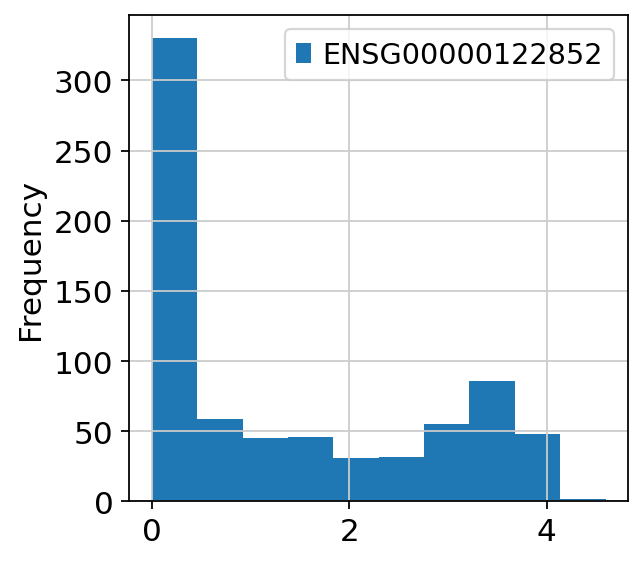

In [368]:
adata[ adata.obs.cell_type=="Alveolar cell type 2", adata.var.symbol=="SFTPA1"].to_df().plot.hist()

It is present in ours, which maybe points to a bad annotation on their part.

We also check for presence of PDPN or T1 alpha in aveolar cells type 1. It has been identified as a differentation marker from AT2 to AT1 cells. It is mucin protein, whose function is not totally understood.

The article mentions that AT1 cells tend no to appear in scRNAseq studies, apparently because of the process of dissociation by tripsin. 
Coincidentally we can see in the below histogram that we have few of them But the ones that we do have do present a normal level of PDPN.

In [370]:
adata[ adata.obs.cell_type=="Alveolar cell type 1", adata.var.symbol=="PDPN"].to_df().plot.hist()

<Axes: ylabel='Frequency'>

Compared to AT2 cells the distrbution is mucho fatter and longer.

<Axes: ylabel='Frequency'>

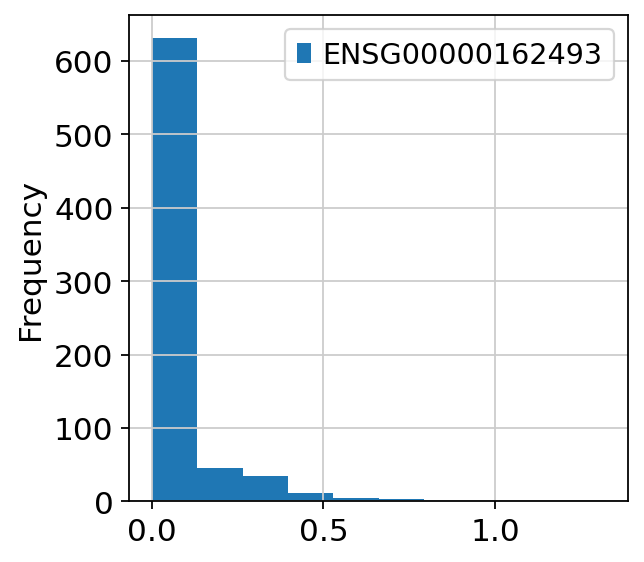

In [369]:
adata[ adata.obs.cell_type=="Alveolar cell type 2", adata.var.symbol=="PDPN"].to_df().plot.hist()

### Uncertainty of predictions

Passing in `soft=True` to SCANVI’s `predict` method returns prediction probabilities from the cell type classifier. However, these shouldn’t be interpreted as p-values or significance levels, nor are they typically well calibrated (i.e. the classifier is confident even when giving wrong predictions).

But I gather that the uncertainty we get from the distances in the neighbourhood graph embedding are also not p-values or significance levels.

In [43]:
uncerts = model.predict(soft=True)

# uncerts.index = uncerts.index.str.split('_').str[1]
# uncerts['barcode'] = uncerts.index
uncerts_types = query_latent.obs.loc[:,['cell_type']].join(uncerts, how='right')
uncerts_types

cell_type  Alveolar cell type 1  \
index                                                           
Deng_0                        Mast cell          9.054817e-22   
Deng_1       T cell CD8 effector memory          4.979777e-13   
Deng_2             T cell CD8 activated          2.160324e-15   
Deng_3             T cell CD8 activated          1.476816e-16   
Deng_4                        Mast cell          2.522743e-22   
...                                 ...                   ...   
Deng_421706                  T cell CD4          2.766550e-12   
Deng_421707                 Plasma cell          3.872381e-24   
Deng_421708                      B cell          3.816807e-27   
Deng_421709        T cell CD8 activated          9.282134e-20   
Deng_421710                      B cell          3.508842e-24   

             Alveolar cell type 2        B cell  B cell dividing  \
index                                                              
Deng_0               3.541376e-29  2.051523e-22     9.653448e-22   
Deng_1               4.418074e-15  5.577916e-13     3.059810e-14   
Deng_2               1.721042e-21  1.146890e-20     3.343751e-17   
Deng_3               1.559021e-22  2.267320e-18     9.047587e-18   
Deng_4               2.836689e-29  4.359540e-22     7.162567e-22   
...                           ...           ...              ...   
Deng_421706          1.579235e-14  4.139809e-03     7.199983e-09   
Deng_421707          4.697035e-24  6.980788e-21     1.418644e-21   
Deng_421708          5.180171e-27  1.000000e+00     9.784778e-20   
Deng_421709          8.159031e-25  7.455119e-16     4.615935e-18   
Deng_421710          2.393085e-26  9.999998e-01     1.117479e-17   

                 Ciliated          Club     DC mature  \
index                                                   
Deng_0       1.822777e-14  3.447125e-24  2.529342e-23   
Deng_1       4.377005e-13  4.365531e-17  4.107681e-11   
Deng_2       5.629415e-17  2.051194e-19  3.696528e-15   
Deng_3       1.509585e-16  2.225806e-20  5.544503e-15   
Deng_4       2.198790e-14  1.414605e-24  1.242077e-23   
...                   ...           ...           ...   
Deng_421706  9.099240e-12  8.430429e-15  4.095183e-07   
Deng_421707  8.707477e-20  1.598913e-11  3.264100e-21   
Deng_421708  3.205769e-21  2.233160e-29  1.861488e-15   
Deng_421709  1.450964e-16  2.433000e-20  2.323875e-13   
Deng_421710  5.935995e-18  1.328660e-24  1.973763e-13   

             Endothelial cell arterial  Endothelial cell capillary  ...  \
index                                                               ...   
Deng_0                    1.087038e-17                3.479553e-20  ...   
Deng_1                    5.334172e-17                3.132177e-16  ...   
Deng_2                    4.490130e-17                3.340513e-17  ...   
Deng_3                    8.728039e-18                8.549658e-19  ...   
Deng_4                    2.415446e-18                2.161897e-20  ...   
...                                ...                         ...  ...   
Deng_421706               1.300662e-11                3.593546e-10  ...   
Deng_421707               1.499210e-21                6.352243e-23  ...   
Deng_421708               1.883228e-24                1.669843e-23  ...   
Deng_421709               1.736190e-18                1.321371e-21  ...   
Deng_421710               4.315067e-21                2.251749e-21  ...   

             Tumor cells LUAD mitotic  Tumor cells LUSC  \
index                                                     
Deng_0                   2.233795e-25      6.167698e-20   
Deng_1                   2.601453e-17      1.131477e-18   
Deng_2                   8.540039e-16      7.281520e-20   
Deng_3                   9.588839e-18      4.383323e-21   
Deng_4                   1.982629e-26      2.463104e-19   
...                               ...               ...   
Deng_421706              2.794079e-11      2.033870e-11   
Deng_421707              1.221401e-19      2.79547

<Axes: ylabel='cell_type'>

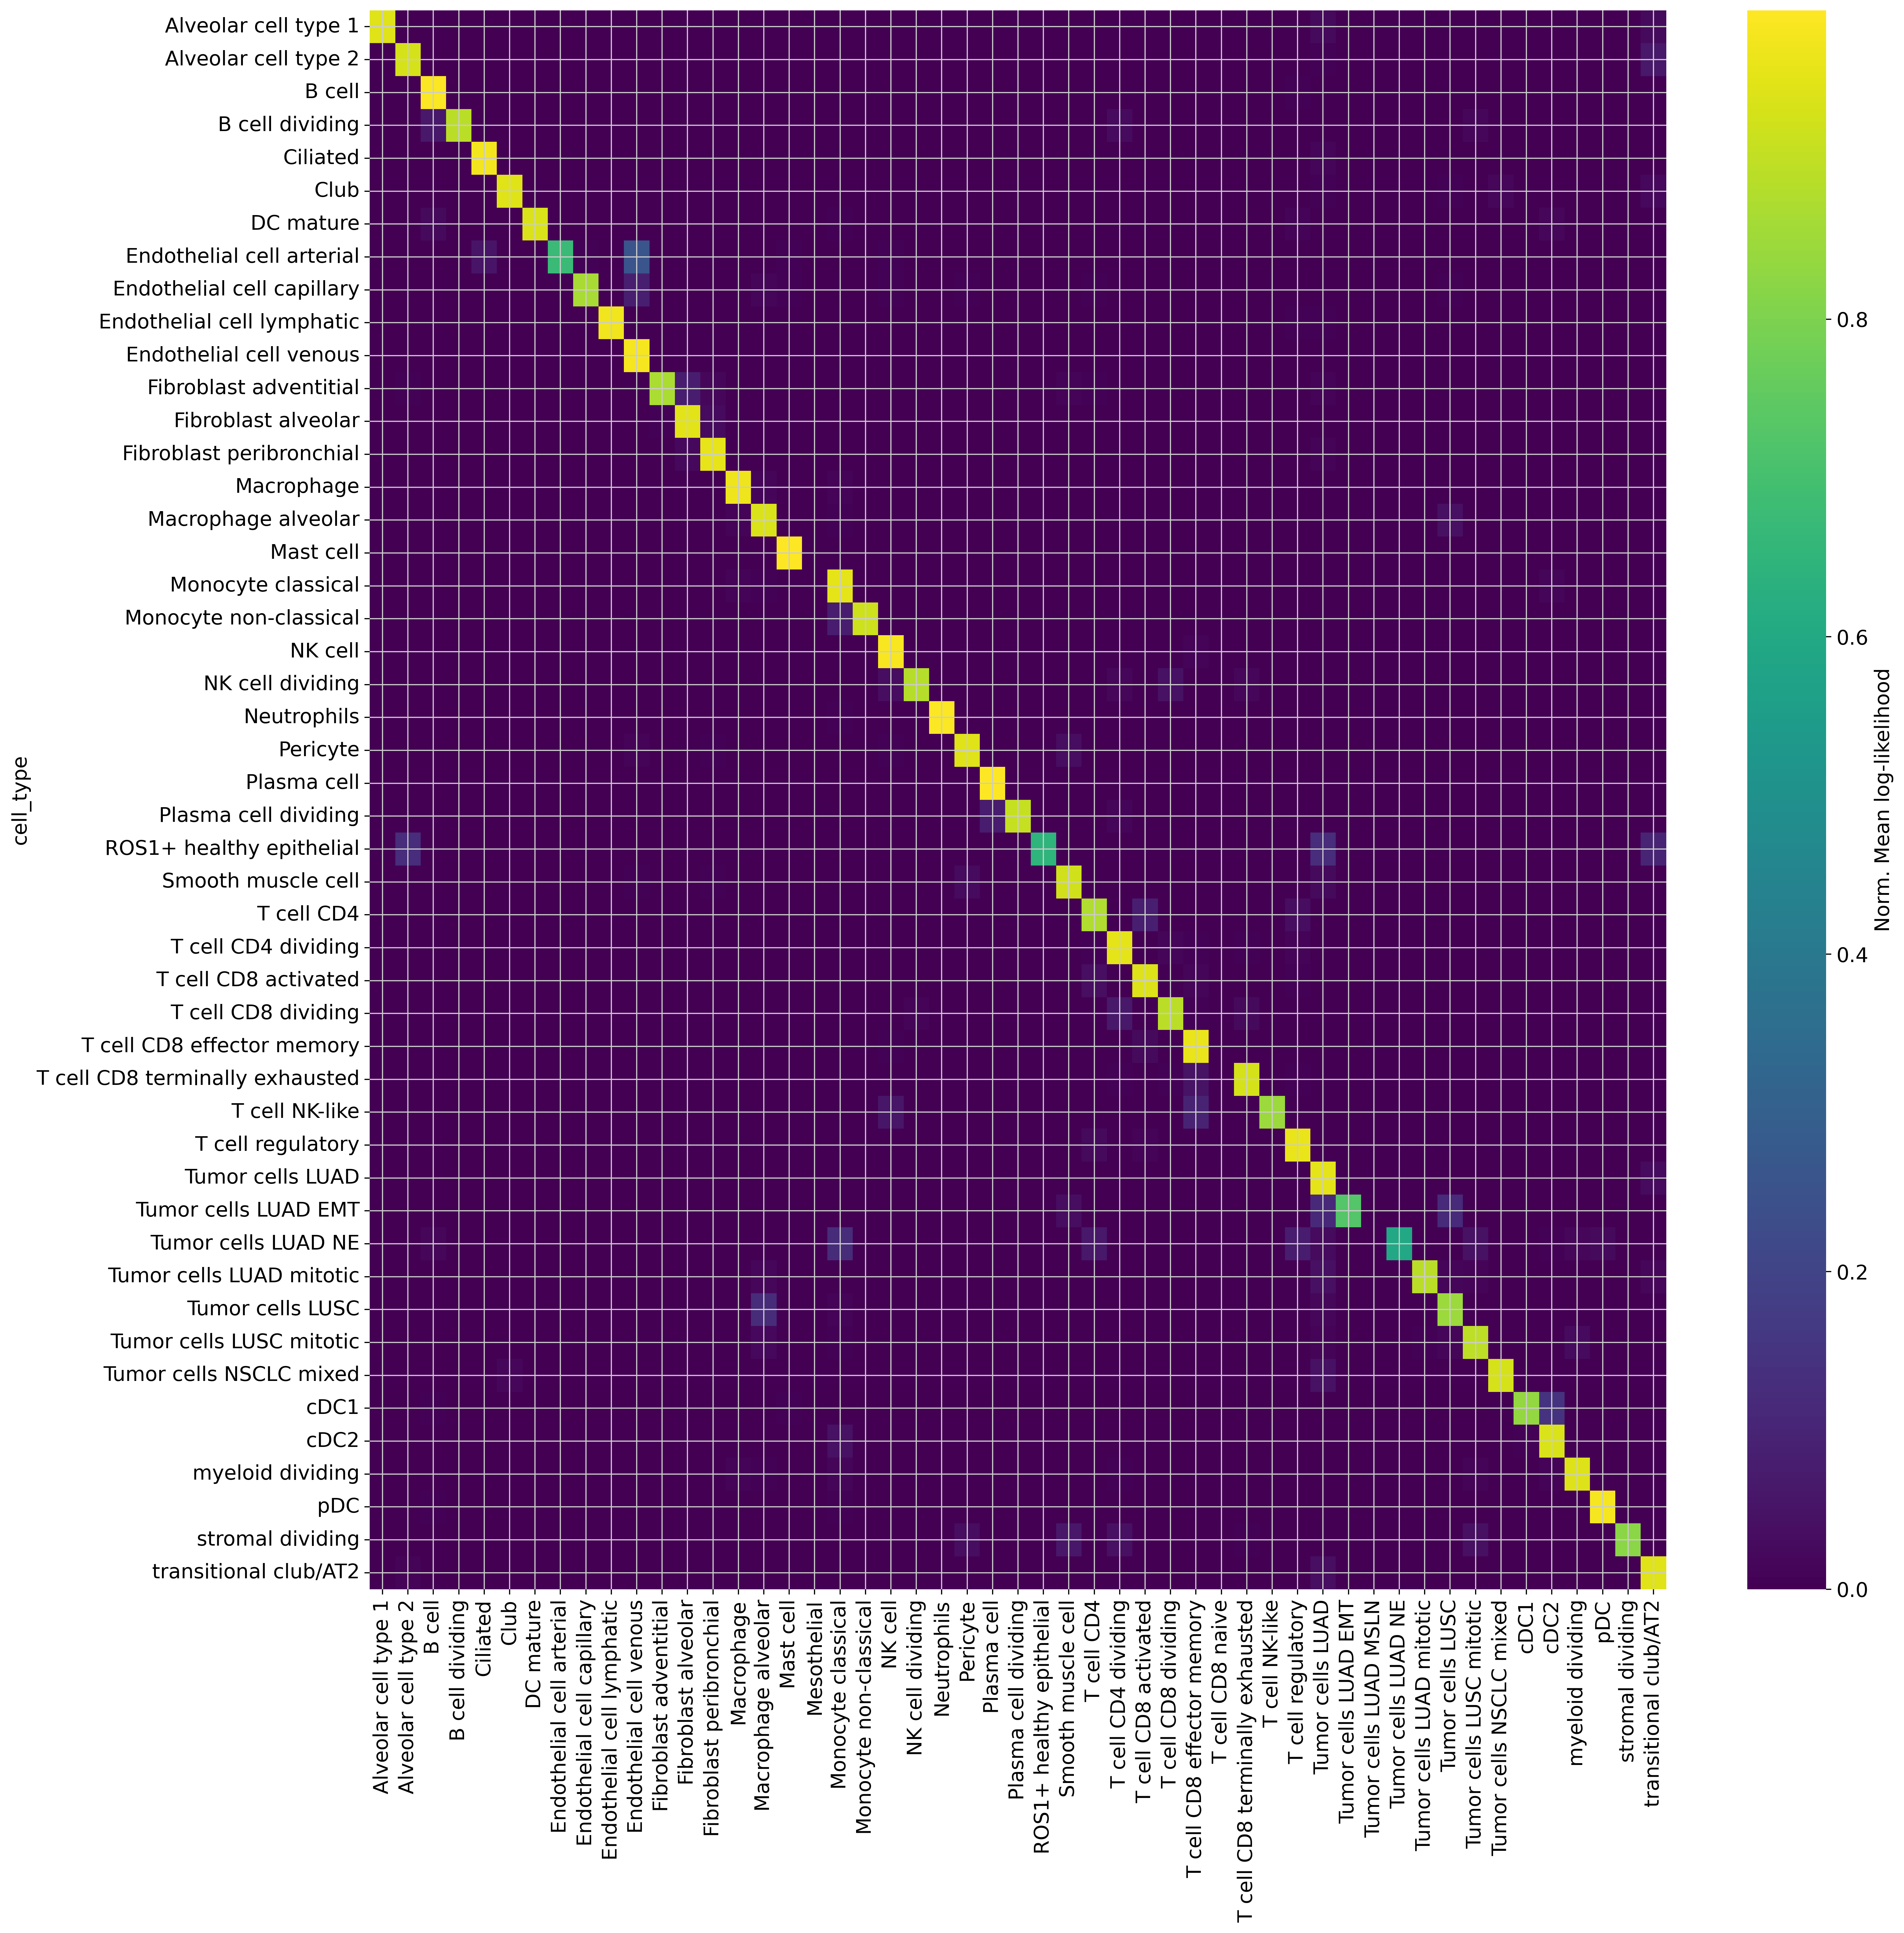

In [44]:
uncerts_group = uncerts_types.groupby(['cell_type']).mean()
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(uncerts_group, cmap="viridis", cbar_kws={'label': 'Norm. Mean log-likelihood'}, ax=ax)

We can see that endothelial cell capillar, ROS+1 healty epithelial cells and Tumor cells LUAD NE had the lowest log-lieklihood. That may be because we don't have many LUAD NE in our reference dataset for we don't have metastasis.

But in overall the log-likelihood is pretty on point.

### Prediction score

To actually asses the quality of our reference model we will compare against the actual annotations from the article. 

We must create an equivalence dict for these cell types and the ones we predict.

It helps to put the similar types next to each other to notice incositencies in assignment. But this assignment is very approximate. So the score we can infer from this is only qualitative.

In [366]:
cell_type_mapping = {
    "Cycling cytotoxic (low) T cells": ["T cell CD8 activated", "T cell CD8 effector memory", 'T cell CD8 naive', 'T cell CD8 dividing'],
    "Cycling exhausted cytotoxic T cells": ["T cell CD8 terminally exhausted", 'T cell CD8 dividing'],
    "Exhausted cytotoxic T cells 2": ["T cell CD8 terminally exhausted", "T cell CD8 effector memory"],
    "Cytotoxic T cells (low)": ["T cell CD8 activated", 'T cell CD8 naive', "T cell CD8 effector memory"],
    "Exhausted cytotoxic T cells": ["T cell CD8 terminally exhausted"],
    "CD8+ (low) T cells": ["T cell CD8 activated", 'T cell CD8 effector memory', 'T cell CD8 naive'],
    "Downregulated T cells": ["T cell CD4", 'T cell CD4 dividing'], # downregulated T cells, corresponding to states with low or no expression of genes defining the exhausted, naive, or cytotoxic state, but with moderate expression of the global CD3 markers. The non-cytotoxic state includes moderate expression of CD4 and these cells play an active role in the adaptive immune system through the release of specific cytokines to control and polarise the immune response
    "CD8+ T cells": ["T cell CD8 activated", "T cell CD8 effector memory", "T cell CD8 naive"],
    "Naive T cells": ["T cell CD8 naive", "T cell NK-like"],
    "Tregs": ["T cell regulatory"],
    "Exhausted T cells": ["T cell CD8 terminally exhausted", 'T cell CD4', 'T cell regulatory'],
    "B cells": ["B cell",  "B cell dividing"],
    "LYZ+ B cells": ["B cell",  "B cell dividing"],
    "Plasma B cells": ["Plasma cell", "B cell"],
    "NK cells (higher cytotoxicity)": ["NK cell"],
    "NK cells (lower cytotoxicity)": ["NK cell"],
    "cDC2": ["cDC2"],
    "pDCs": ["pDC", ],
    "STAB+ anti-inflammatory cells": ["pDC", "Macrophage alveolar"],
    "Cycling immature anti-inflammatory myeloid cells": ["Monocyte non-classical", "Monocyte classical", "myeloid dividing", "B cell dividing", "Plasma cell dividing"],
    "Immature anti-inflammatory myeloid cells": ["Monocyte non-classical", "Monocyte classical"],
    "Immature myeloid cells 1": ["Monocyte classical", 'Monocyte non-classical', 'myeloid dividing'],
    "Immature myeloid cells 2": ["Monocyte classical", 'Monocyte non-classical', 'myeloid dividing'],
    "Cycling anti-inflammatory macrophages": ["Macrophage", "Macrophage alveolar", "myeloid dividing" ],
    "SPP1+ cycling anti-inflammatory macrophages": ["Macrophage", "Macrophage alveolar", "myeloid dividing"],
    "SPP1+ macrophages": ["Macrophage alveolar", "Macrophage"],
    "Anti-inflammatory (medium) macrophages": ["Macrophage", "Macrophage alveolar","Monocyte classical", 'Monocyte non-classical'],
    "Anti-inflammatory (high) alveolar macrophages": ["Macrophage", "Macrophage alveolar"],
    "Pro-inflammatory (low) macrophages": ["Macrophage", "Macrophage alveolar", "Monocyte classical", 'Monocyte non-classical', 'Neutrophils'],
    "Pro-inflammatory (medium) macrophages": ["Macrophage", "Macrophage alveolar"],
    "Anti-inflammatory (high) macrophages": ["Macrophage", "Macrophage alveolar"],
    "Pro-inflammatory (high) macrophages": ["Macrophage", "Macrophage alveolar"],
    "Collagen+ macrophages": ["Macrophage", "Macrophage alveolar"],
    # "Cycling myeloid cells,2,0 (to remove)": ["myeloid dividing"], # we romeve htem because it says to remove and they are calssifed as cd4 cells
    "Mast cells": ["Mast cell"],
    # "Mast cells,3 (to remove)": ["Mast cell"],
    # "Mast cells,9 (to remove)": ["Mast cell"],
    "Cycling mast cells": ["myeloid dividing", "Mast cell"],
    "CAMLs": ["Macrophage", "Macrophage alveolar", "Alveolar cell type 1", "Alveolar cell type 2", "transitional club/AT2","Tumor cells LUAD mitotic",
        "Tumor cells LUAD NE",
        "Tumor cells LUAD EMT"],
    "AT2 cells": ["Alveolar cell type 2",
        "Alveolar cell type 1",
        "Club",
        "ROS1+ healthy epithelial",
        "Tumor cells LUSC",
        "Tumor cells LUSC mitotic",
        "Tumor cells NSCLC mixed",
        "Tumor cells LUAD",
        "Tumor cells LUAD mitotic",
        "Tumor cells LUAD NE",
        "Tumor cells LUAD EMT"
                 ],
    "Ciliated epithelial cells": ["Ciliated"],
    "Epithelial cells": ["stromal dividing",
        "transitional club/AT2",
        "Alveolar cell type 2",
        "Alveolar cell type 1",
        "Ciliated",
        "Club",
        "ROS1+ healthy epithelial",
        "Tumor cells LUSC",
        "Tumor cells LUSC mitotic",
        "Tumor cells NSCLC mixed",
        "Tumor cells LUAD",
        "Tumor cells LUAD mitotic",
        "Tumor cells LUAD NE",
        "Tumor cells LUAD EMT"
                        ],
    "Cycling epithelial cells": ["stromal dividing",
        "transitional club/AT2",
        "Alveolar cell type 2",
        "Alveolar cell type 1",
        "Tumor cells LUSC",
        "Tumor cells LUSC mitotic",
        "Tumor cells NSCLC mixed",
        "Tumor cells LUAD",
        "Tumor cells LUAD mitotic",
        "Tumor cells LUAD NE",
        "Tumor cells LUAD EMT"],
    "Activated adventitial fibroblasts": ["Fibroblast adventitial", "Fibroblast peribronchial", "Smooth muscle cell", "Fibroblast alveolar", 'stromal dividing'],
    "Transitioning epithelial cells": ["transitional club/AT2",
        "Alveolar cell type 2",
        "Alveolar cell type 1",
        "Club",
        "ROS1+ healthy epithelial",
        "Tumor cells LUSC",
        "Tumor cells LUSC mitotic",
        "Tumor cells NSCLC mixed",
        "Tumor cells LUAD",
        "Tumor cells LUAD mitotic",
        "Tumor cells LUAD NE",
        "Tumor cells LUAD EMT"],
    "Cycling epithelial cells 2": ["Endothelial cell venous", "Fibroblast adventitial"],
    "Lymphatic endothelial cells": ["Endothelial cell arterial",
        "Endothelial cell lymphatic",
        "Endothelial cell venous",
        "Endothelial cell capillary",
        "Smooth muscle cell",
                                   ],
}


We are going to sum the percentage of cells in a source type that were predicted in the corresponding predicted cell types.

The mean is going to be our measure of accuracy. True postivies.

In [367]:
df = query_latent.obs.groupby(["cell_type", "source_type"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

accs = {}
for source_type, pred_types in cell_type_mapping.items():
    accs[source_type] = sum(norm_df.loc[pred_types, source_type])

print("Accuracy: ", np.mean(list(accs.values())))

Accuracy:  0.5988344827677585


In [365]:
accs
sorted_dict = dict(sorted(accs.items(), key=lambda item: item[1]))
sorted_dict

{'Cycling myeloid cells,2,0 (to remove)': 0.0,
 'Cycling epithelial cells 2': 0.0,
 'Immature myeloid cells 2': 0.002954694681549573,
 'Exhausted T cells': 0.0034482758620689655,
 'Immature anti-inflammatory myeloid cells': 0.007029876977152899,
 'Cycling epithelial cells': 0.0096051227321238,
 'Naive T cells': 0.026494277236116998,
 'Mast cells,9 (to remove)': 0.027777777777777776,
 'Exhausted cytotoxic T cells 2': 0.04148894920511826,
 'NK cells (lower cytotoxicity)': 0.05615969015343364,
 'Immature myeloid cells 1': 0.056837366347777155,
 'Cycling cytotoxic (low) T cells': 0.12233375156838143,
 'Cytotoxic T cells (low)': 0.13432647393005934,
 'STAB+ anti-inflammatory cells': 0.14788732394366197,
 'Pro-inflammatory (high) macrophages': 0.22520808561236624,
 'CD8+ (low) T cells': 0.2641035803937112,
 'Cycling exhausted cytotoxic T cells': 0.31354466858789626,
 'Collagen+ macrophages': 0.35691987513007284,
 'Exhausted cytotoxic T cells': 0.36363636363636365,
 'Mast cells,3 (to remove)'

## Save predictions

In [31]:
adata_query.obs['cell_type_tumor'] = query_latent.obs['cell_type']

In [32]:
adata_query.obs

Sample Patient                Resource   Sex  \
index                                                                      
Hu_BD_immune01_612637  BD_immune01     P01    Pre-treatment biopsy  Male   
Hu_BD_immune01_698718  BD_immune01     P01    Pre-treatment biopsy  Male   
Hu_BD_immune01_509246  BD_immune01     P01    Pre-treatment biopsy  Male   
Hu_BD_immune01_101435  BD_immune01     P01    Pre-treatment biopsy  Male   
Hu_BD_immune01_400370  BD_immune01     P01    Pre-treatment biopsy  Male   
...                            ...     ...                     ...   ...   
Hu_BD_immune13_111313  BD_immune13     P13  Post-treatment surgery  Male   
Hu_BD_immune13_791956  BD_immune13     P13  Post-treatment surgery  Male   
Hu_BD_immune14_462072  BD_immune14     P14  Post-treatment surgery  Male   
Hu_BD_immune14_124095  BD_immune14     P14  Post-treatment surgery  Male   
Hu_BD_immune15_20126   BD_immune15     P15  Post-treatment surgery  Male   

                        Age Clinical Stage Pathology PD1 Antibody  \
index                                                               
Hu_BD_immune01_612637  68.0           IIIA  Squamous  Toripalimab   
Hu_BD_immune01_698718  68.0           IIIA  Squamous  Toripalimab   
Hu_BD_immune01_509246  68.0           IIIA  Squamous  Toripalimab   
Hu_BD_immune01_101435  68.0           IIIA  Squamous  Toripalimab   
Hu_BD_immune01_400370  68.0           IIIA  Squamous  Toripalimab   
...                     ...            ...       ...          ...   
Hu_BD_immune13_111313  59.0           IIIA  Squamous   Sintilimab   
Hu_BD_immune13_791956  59.0           IIIA  Squamous   Sintilimab   
Hu_BD_immune14_462072  79.0           IIIA  Squamous   Sintilimab   
Hu_BD_immune14_124095  79.0           IIIA  Squamous   Sintilimab   
Hu_BD_immune15_20126   55.0           IIIA     Adeno   Sintilimab   

                                  Chemotherapy Pathologic Response  ...  \
index                                                               ...   
Hu_BD_immune01_612637    Carboplatin+Docetaxel                  NE  ...   
Hu_BD_immune01_698718    Carboplatin+Docetaxel                  NE  ...   
Hu_BD_immune01_509246    Carboplatin+Docetaxel                  NE  ...   
Hu_BD_immune01_101435    Carboplatin+Docetaxel                  NE  ...   
Hu_BD_immune01_400370    Carboplatin+Docetaxel                  NE  ...   
...                                        ...                 ...  ...   
Hu_BD_immune13_111313  Carboplatin+Gemcitabine                NMPR  ...   
Hu_BD_immune13_791956  Carboplatin+Gemcitabine                NMPR  ...   
Hu_BD_immune14_462072  Carboplatin+Gemcitabine                 MPR  ...   
Hu_BD_immune14_124095  Carboplatin+Gemcitabine                 MPR  ...   
Hu_BD_immune15_20126    Carboplatin+Pemetrexed                NMPR  ...   

                      pct_counts_in_top_200_genes pct_counts_in_top_500_genes  \
index                                                                           
Hu_BD_immune01_612637                   36.828238                   50.973347   
Hu_BD_immune01_698718                   34.859121                   48.927782   
Hu_BD_immune01_509246                   41.040680                   53.690054   
Hu_BD_immune01_101435                   33.784729                   48.175345   
Hu_BD_immune01_400370                   45.389427                   59.927361   
...                                           ...                         ...   
Hu_BD_immune13_111313                   43.041798                   57.267299   
Hu_BD_immune13_791956                   41.201106                   55.827736   
Hu_BD_immune14_462072                   40.040022                   55.512098   
Hu_BD_immune14_124095                   39.452055                   54.904110   
Hu_BD_immune15_20126                    42.673883                   58.107837   

                       total_counts_mito  log1p_total_counts_mito  \
index                                     

In [33]:
f'{backup_dir}/{name}_predicted.csv'

'/root/datos/maestria/netopaas/luca_explore/surgeries/Hu_wu_predicted.csv'

In [34]:
adata_query.obs.to_csv(f'{backup_dir}/{name}_predicted.csv')